## Imports


In [73]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Imports dos módulos do projeto
import sys
sys.path.append('../src')

from data import (
    convert_species_to_numeric,
    prepare_data,
    split_data,
    create_scaler,
    apply_scaling,
)

from models import (
    create_baseline,
    create_models,
    train_all_models,
    create_model_pipelines,
    compare_models,
    select_best_model,
    save_model,
    compare_approaches,
    create_comparison_table,
    plot_approach_comparison,
)

from utils import (
    evaluate_model,
    plot_confusion_matrix,
    print_classification_report,
    generate_evaluation_report,
    plot_model_comparison,
)

from predict import predict_interactive

%matplotlib inline


## Dados


In [74]:
# Baixar dataset caso não esteja presente
DATASET_URL = 'https://raw.githubusercontent.com/marcelovca90-inatel/AG2/refs/heads/main/iris.csv'
DATASET_PATH = '../data/raw/iris.csv'

if not os.path.exists(DATASET_PATH):
    response = requests.get(DATASET_URL)
    with open(DATASET_PATH, 'wb') as file:
        file.write(response.content)


In [75]:
df = pd.read_csv(DATASET_PATH)
df.head()


,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## EDA


In [76]:
# Informações gerais do dataset
print("=" * 60)
print("INFORMAÇÕES GERAIS DO DATASET")
print("=" * 60)
df.info()
print("\n")

# Estatísticas descritivas gerais
print("=" * 60)
print("ESTATÍSTICAS DESCRITIVAS GERAIS")
print("=" * 60)
print(df.describe())
print("\n")

# Verificação de valores faltantes
print("=" * 60)
print("VALORES FALTANTES")
print("=" * 60)
missing = df.isnull().sum()
print(missing)
print(f"\nTotal de valores faltantes: {missing.sum()}")
print("\n")

# Análise de balanceamento de classes
print("=" * 60)
print("BALANCEAMENTO DE CLASSES")
print("=" * 60)
class_counts = df['species'].value_counts()
print(class_counts)
print("\nPercentual por classe:")
print((class_counts / len(df) * 100).round(2))
print("\n")

# Estatísticas descritivas por espécie
print("=" * 60)
print("ESTATÍSTICAS DESCRITIVAS POR ESPÉCIE")
print("=" * 60)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for species in df['species'].unique():
    print(f"\n{species}:")
    print(df[df['species'] == species][numeric_cols].describe())
    print("-" * 60)


INFORMAÇÕES GERAIS DO DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sepal_length_cm  150 non-null    float64
 1   sepal_width_cm   150 non-null    float64
 2   petal_length_cm  150 non-null    float64
 3   petal_width_cm   150 non-null    float64
 4   species          150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


ESTATÍSTICAS DESCRITIVAS GERAIS
       sepal_length_cm  sepal_width_cm  petal_length_cm  petal_width_cm
count       150.000000      150.000000       150.000000      150.000000
mean          5.843333        3.054000         3.758667        1.198667
std           0.828066        0.433594         1.764420        0.763161
min           4.300000        2.000000         1.000000        0.100000
25%           5.100000        2.800000         1.600000        0.300000
50%           5.800000    

In [77]:
# Análise de qualidade dos dados
print("=" * 60)
print("ANÁLISE DE QUALIDADE DOS DADOS")
print("=" * 60)

# Verificação de duplicatas
print("\n1. DUPLICATAS:")
duplicates = df.duplicated().sum()
print(f"Total de linhas duplicadas: {duplicates}")
if duplicates > 0:
    print("\nLinhas duplicadas:")
    print(df[df.duplicated(keep=False)])

# Identificação de outliers usando IQR
print("\n" + "=" * 60)
print("2. OUTLIERS (Método IQR):")
print("=" * 60)

numeric_cols = df.select_dtypes(include=[np.number]).columns
outliers_summary = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_count = len(outliers)
    outliers_summary[col] = {
        'count': outliers_count,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers': outliers
    }
    
    print(f"\n{col}:")
    print(f"  Limite inferior: {lower_bound:.2f}")
    print(f"  Limite superior: {upper_bound:.2f}")
    print(f"  Número de outliers: {outliers_count}")
    if outliers_count > 0:
        print(f"  Outliers por espécie:")
        print(outliers['species'].value_counts())

print("\n" + "=" * 60)
print("RESUMO DE OUTLIERS")
print("=" * 60)
for col, info in outliers_summary.items():
    print(f"{col}: {info['count']} outlier(s)")


ANÁLISE DE QUALIDADE DOS DADOS

1. DUPLICATAS:
Total de linhas duplicadas: 3

Linhas duplicadas:
     sepal_length_cm  sepal_width_cm  petal_length_cm  petal_width_cm  \
9                4.9             3.1              1.5             0.1   
34               4.9             3.1              1.5             0.1   
37               4.9             3.1              1.5             0.1   
101              5.8             2.7              5.1             1.9   
142              5.8             2.7              5.1             1.9   

            species  
9       Iris-setosa  
34      Iris-setosa  
37      Iris-setosa  
101  Iris-virginica  
142  Iris-virginica  

2. OUTLIERS (Método IQR):

sepal_length_cm:
  Limite inferior: 3.15
  Limite superior: 8.35
  Número de outliers: 0

sepal_width_cm:
  Limite inferior: 2.05
  Limite superior: 4.05
  Número de outliers: 4
  Outliers por espécie:
species
Iris-setosa        3
Iris-versicolor    1
Name: count, dtype: int64

petal_length_cm:
  Limite

## Visualizações


1. HISTOGRAMAS - Distribuição das features por espécie


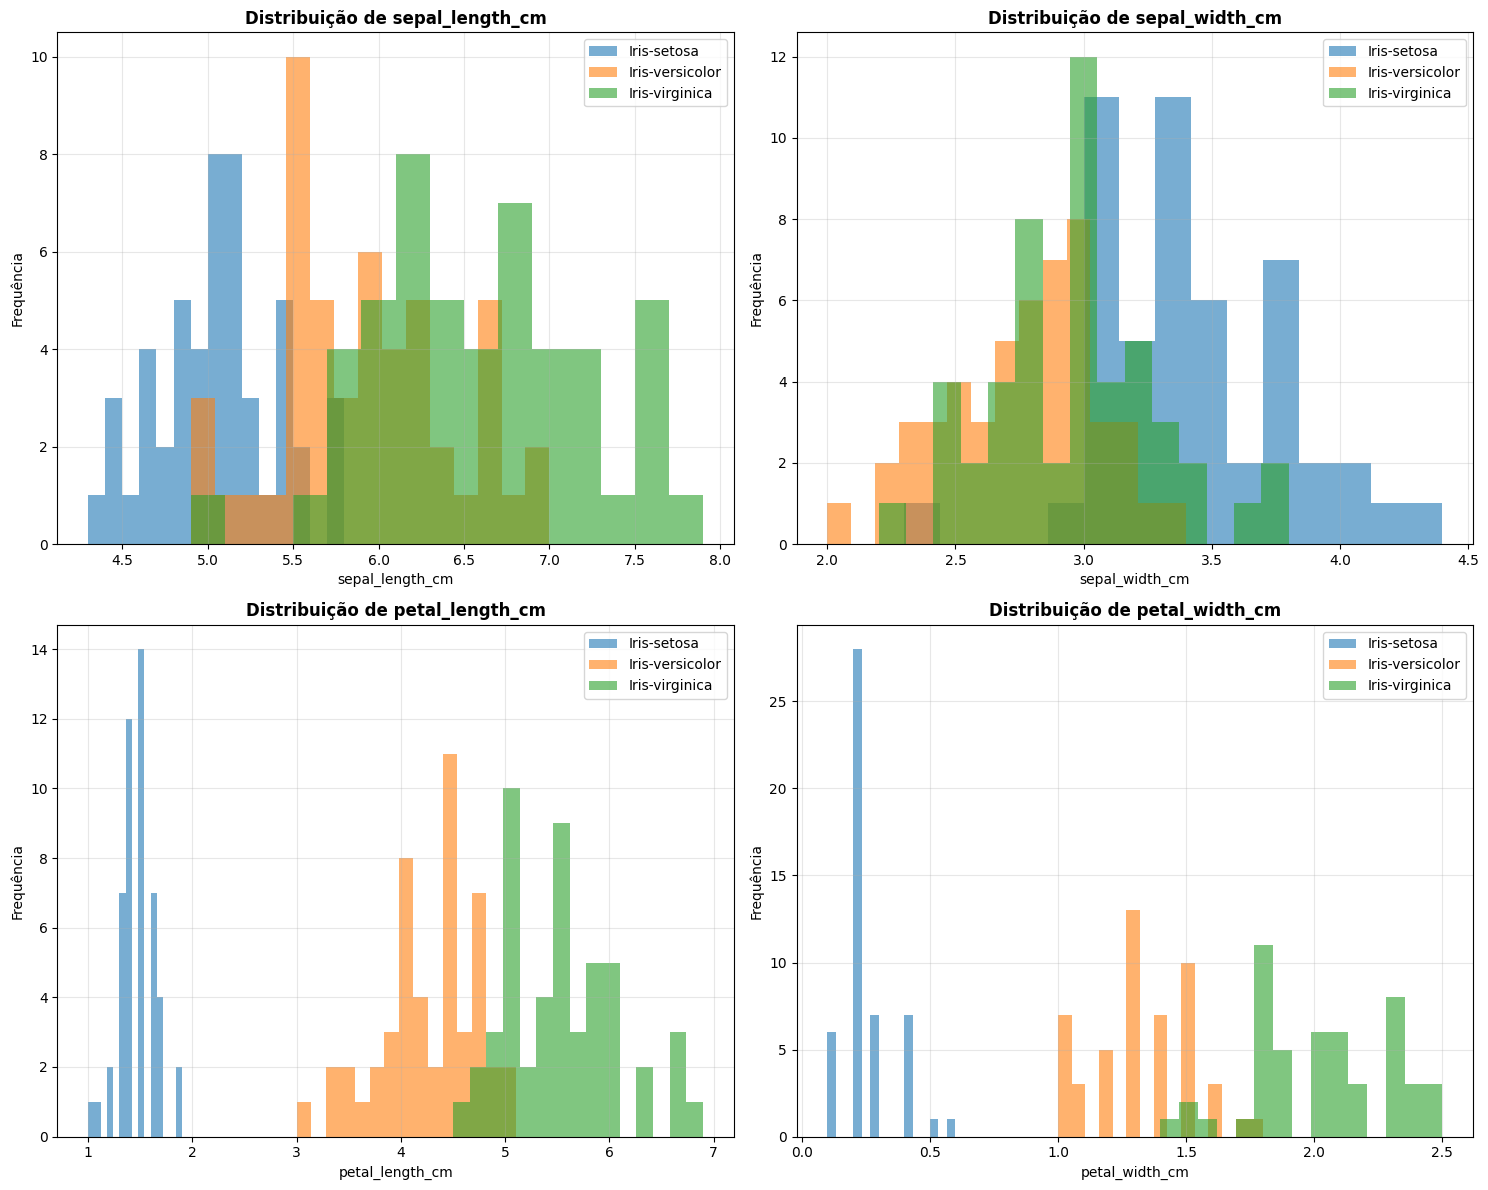

In [78]:
# 1. Histogramas por espécie
print("1. HISTOGRAMAS - Distribuição das features por espécie")
print("=" * 60)

numeric_cols = df.select_dtypes(include=[np.number]).columns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    for species in df['species'].unique():
        axes[idx].hist(df[df['species'] == species][col], 
                      alpha=0.6, label=species, bins=15)
    axes[idx].set_title(f'Distribuição de {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequência')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


2. BOXPLOTS - Comparação de features por espécie


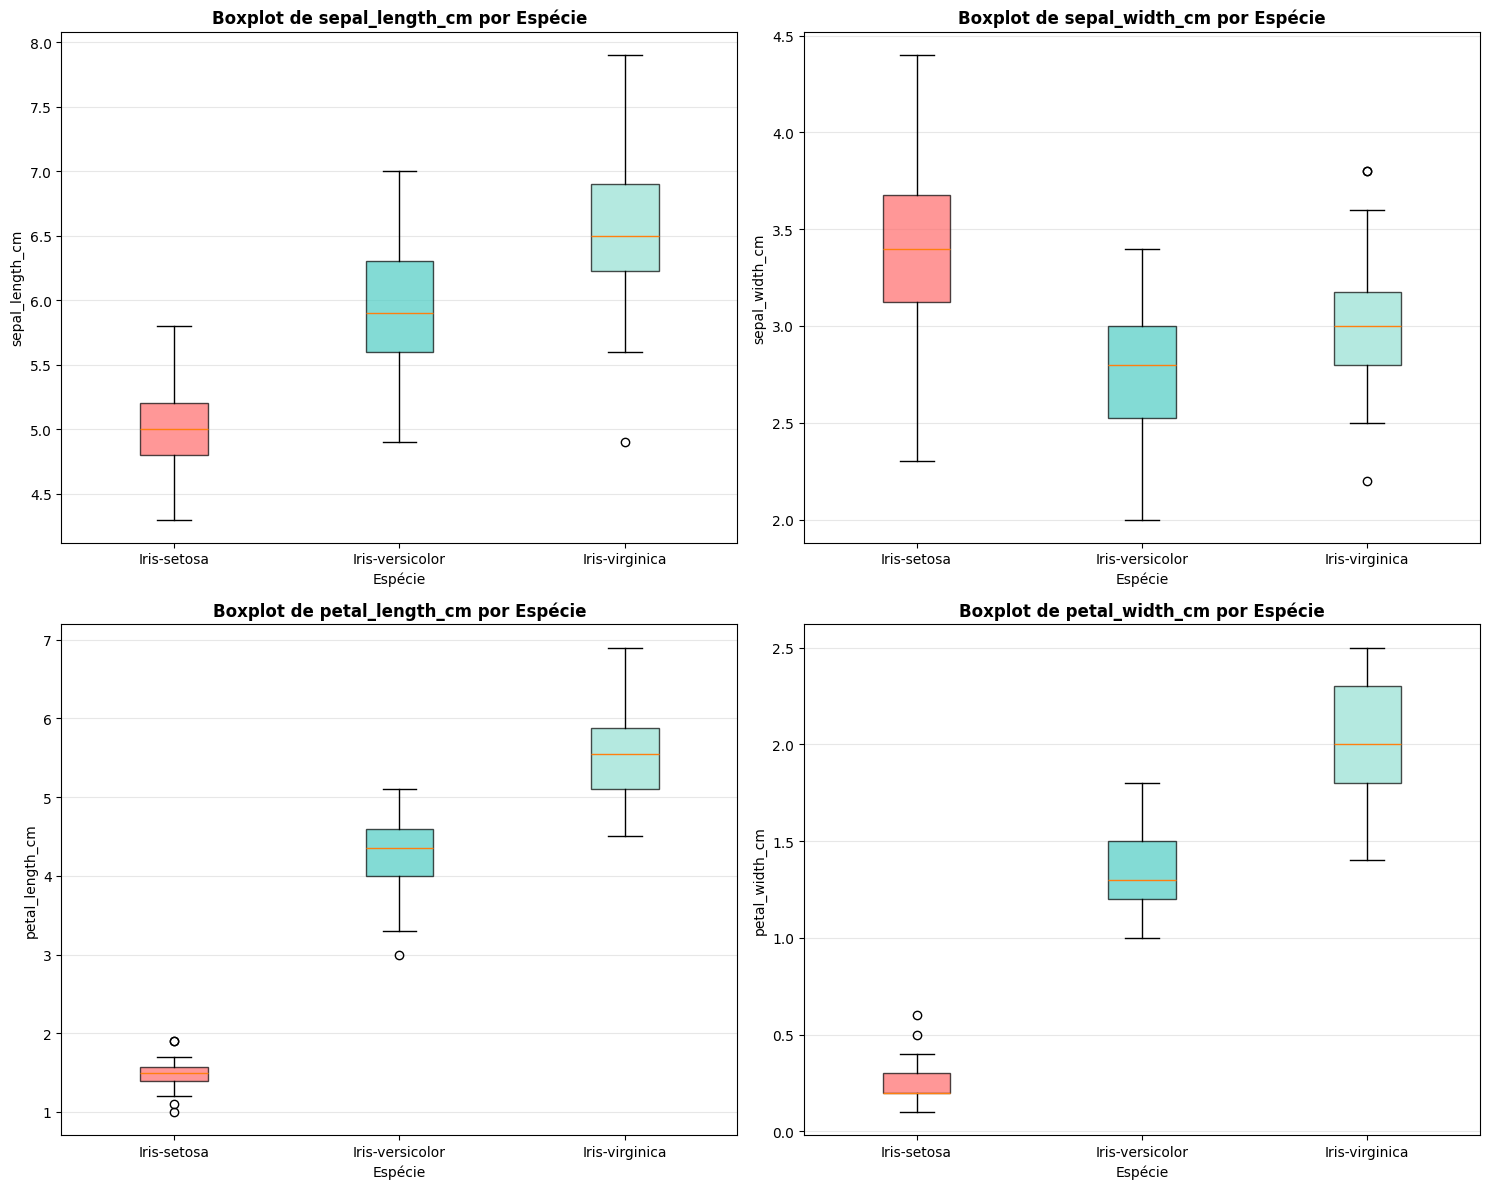

In [79]:
# 2. Boxplots por espécie
print("2. BOXPLOTS - Comparação de features por espécie")
print("=" * 60)

numeric_cols = df.select_dtypes(include=[np.number]).columns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    data_to_plot = [df[df['species'] == species][col].values 
                    for species in df['species'].unique()]
    bp = axes[idx].boxplot(data_to_plot, labels=df['species'].unique(), 
                           patch_artist=True)
    
    # Colorir os boxplots
    colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[idx].set_title(f'Boxplot de {col} por Espécie', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col)
    axes[idx].set_xlabel('Espécie')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


3. PAIRPLOT - Relações entre features coloridas por espécie


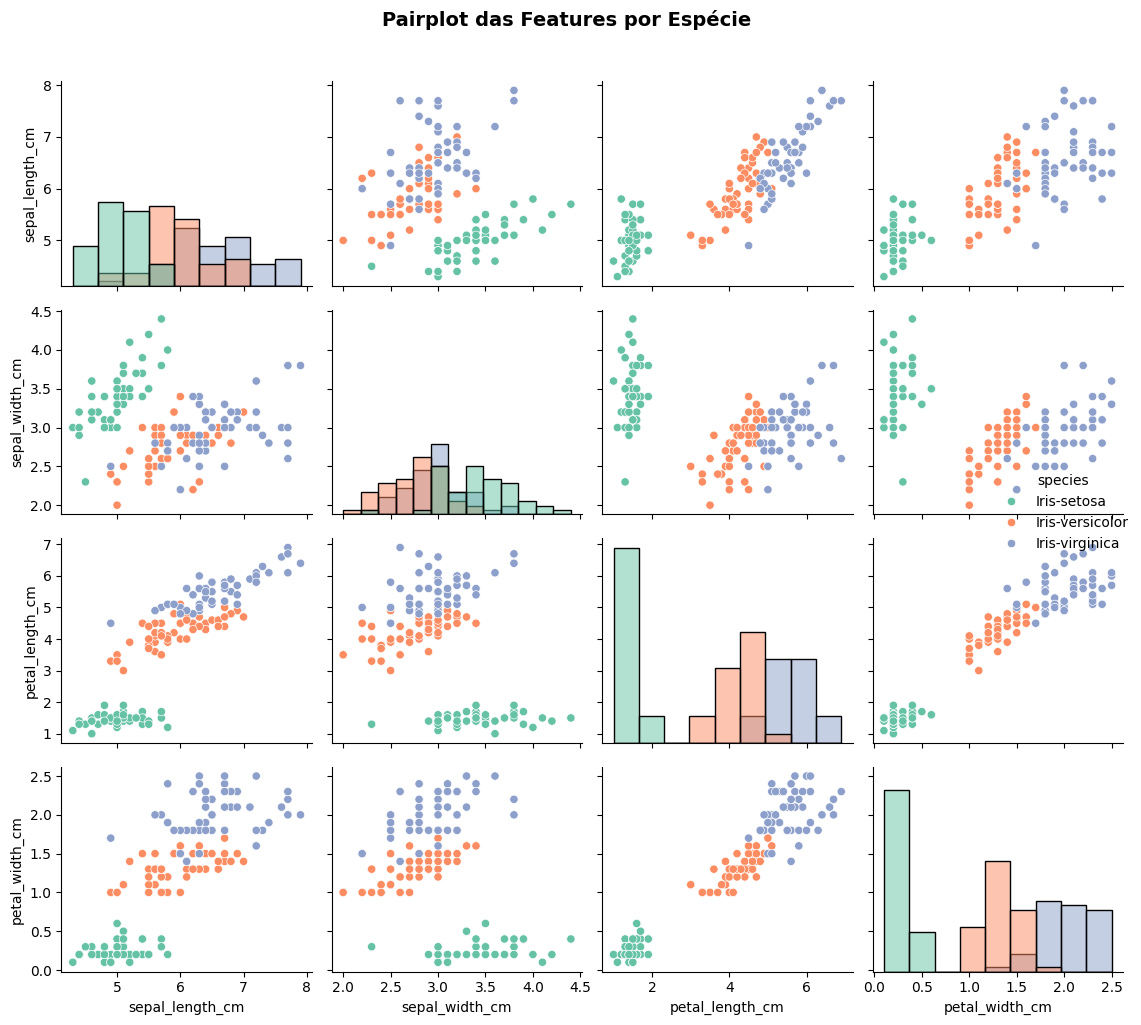

In [80]:
# 3. Pairplot - Relações entre todas as features
print("3. PAIRPLOT - Relações entre features coloridas por espécie")
print("=" * 60)

sns.pairplot(df, hue='species', diag_kind='hist', palette='Set2', height=2.5)
plt.suptitle('Pairplot das Features por Espécie', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


4. MATRIZ DE CORRELAÇÃO


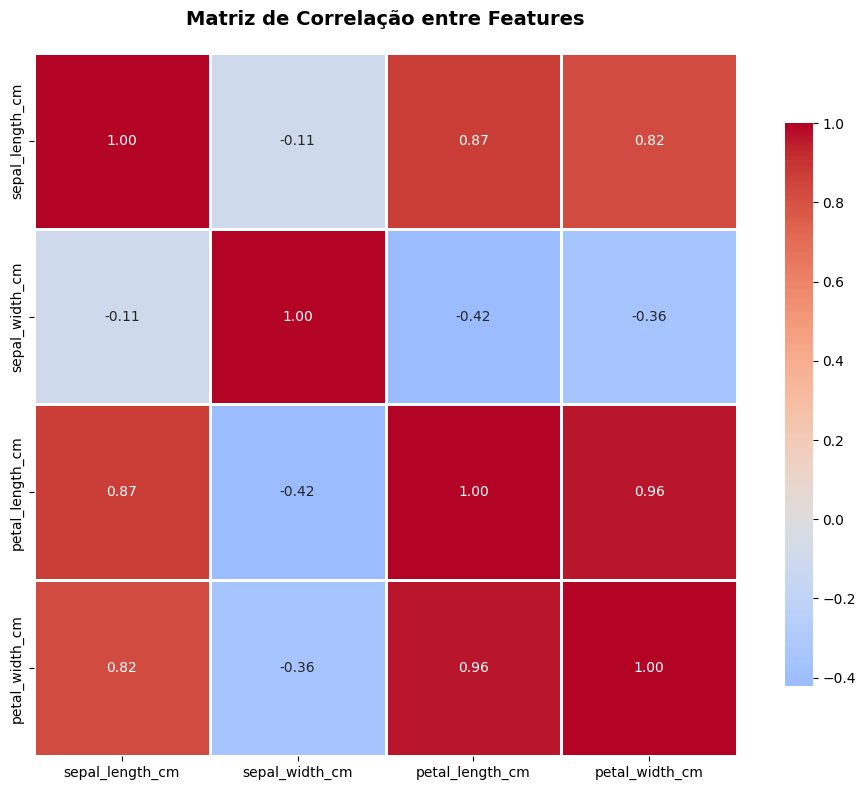


Valores de correlação:
                 sepal_length_cm  sepal_width_cm  petal_length_cm  \
sepal_length_cm         1.000000       -0.109369         0.871754   
sepal_width_cm         -0.109369        1.000000        -0.420516   
petal_length_cm         0.871754       -0.420516         1.000000   
petal_width_cm          0.817954       -0.356544         0.962757   

                 petal_width_cm  
sepal_length_cm        0.817954  
sepal_width_cm        -0.356544  
petal_length_cm        0.962757  
petal_width_cm         1.000000  


In [81]:
# 4. Matriz de correlação
print("4. MATRIZ DE CORRELAÇÃO")
print("=" * 60)

# Calcular correlação apenas entre features numéricas
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação entre Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Exibir valores da correlação
print("\nValores de correlação:")
print(correlation_matrix)


5. SCATTER PLOTS - Relações entre pares de features mais relevantes


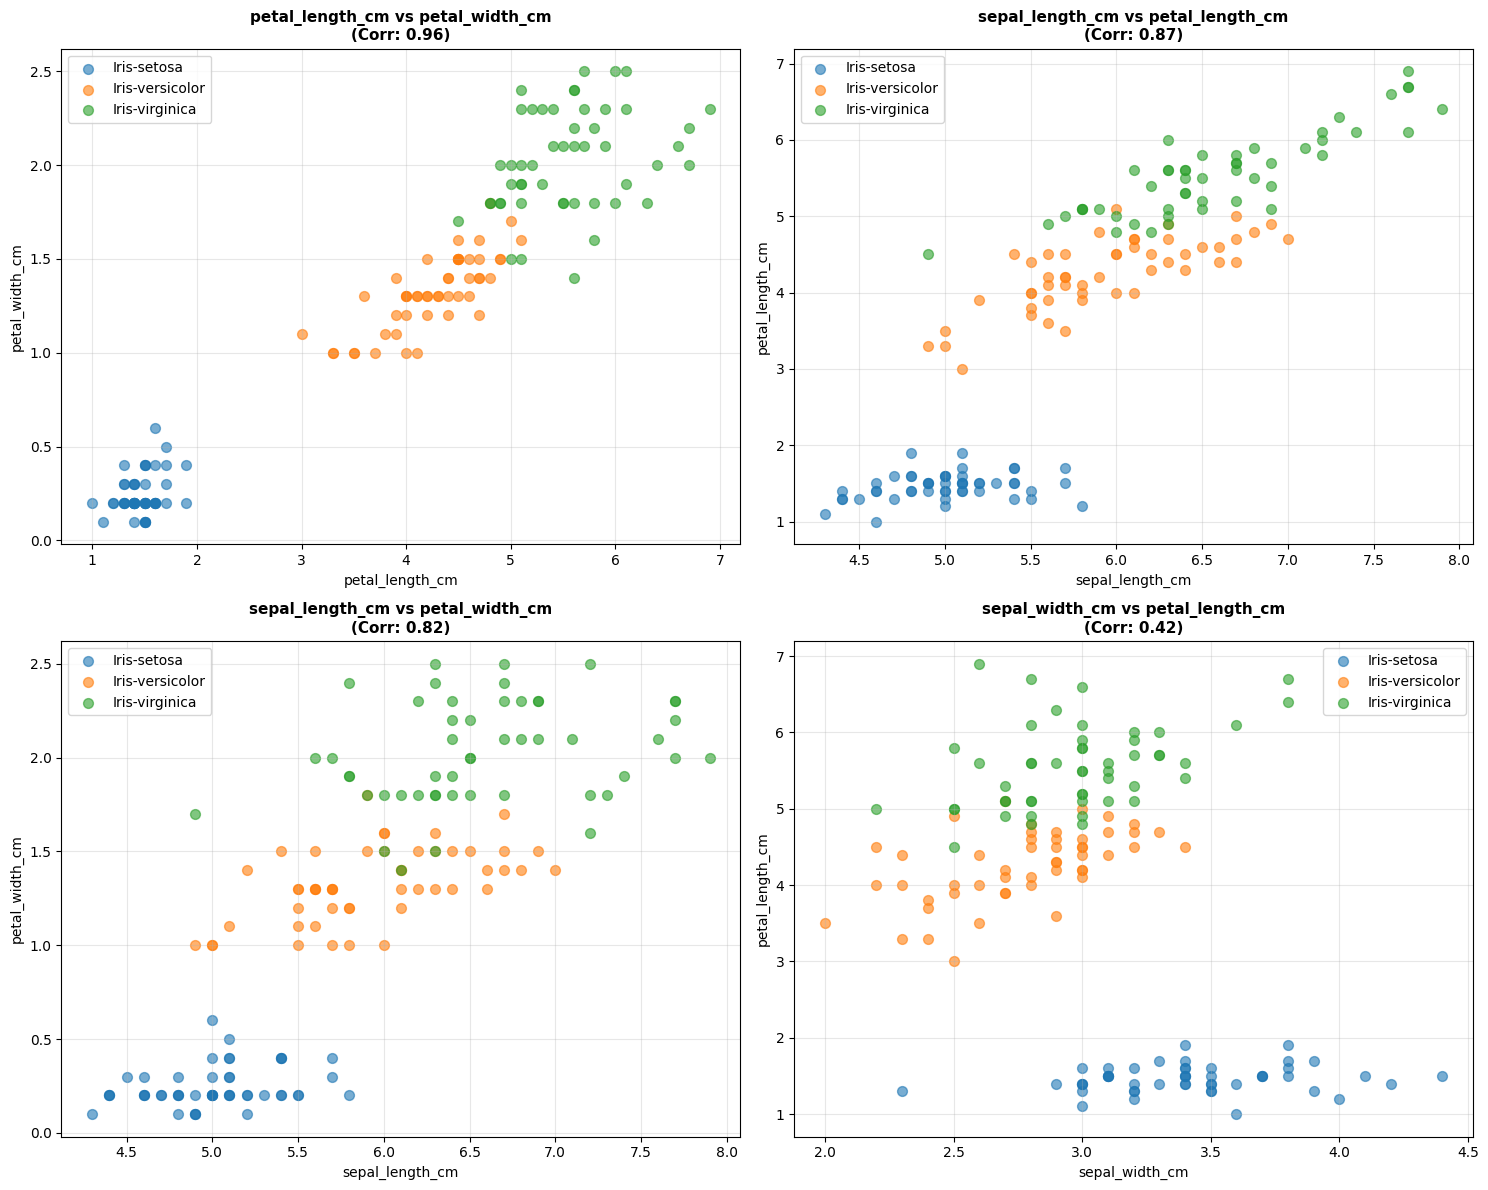

In [82]:
# 5. Scatter plots das relações mais relevantes
print("5. SCATTER PLOTS - Relações entre pares de features mais relevantes")
print("=" * 60)

# Identificar pares com maior correlação (exceto diagonal)
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append((
            correlation_matrix.columns[i],
            correlation_matrix.columns[j],
            abs(correlation_matrix.iloc[i, j])
        ))

# Ordenar por correlação absoluta
corr_pairs.sort(key=lambda x: x[2], reverse=True)

# Plotar os 4 pares com maior correlação
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, (col1, col2, corr) in enumerate(corr_pairs[:4]):
    for species in df['species'].unique():
        species_data = df[df['species'] == species]
        axes[idx].scatter(species_data[col1], species_data[col2], 
                         label=species, alpha=0.6, s=50)
    
    axes[idx].set_xlabel(col1)
    axes[idx].set_ylabel(col2)
    axes[idx].set_title(f'{col1} vs {col2}\n(Corr: {corr:.2f})', 
                       fontsize=11, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Conclusões do EDA (Resumo para Não-Técnicos)

**Principais descobertas:**

1. **Dataset balanceado**: Temos exatamente 50 amostras de cada espécie, o que é ideal para treinamento de modelos.

2. **Dados limpos**: Não há valores faltantes no dataset, facilitando o pré-processamento.

3. **Features discriminantes**: As medidas de pétala (comprimento e largura) são mais eficazes para distinguir as espécies do que as medidas de sépala.

4. **Separação visual**: O pairplot mostra que as espécies formam grupos relativamente bem separados, especialmente quando consideramos as features de pétala.

5. **Correlações**: Existe alta correlação entre algumas features (ex: petal_length e petal_width), o que é esperado e pode ser útil para os modelos.

Essas descobertas indicam que temos boas condições para treinar um modelo de classificação eficaz.


INSIGHTS COMPARATIVOS ENTRE ESPÉCIES

1. MÉDIAS POR ESPÉCIE:
------------------------------------------------------------
                 sepal_length_cm  sepal_width_cm  petal_length_cm  \
species                                                             
Iris-setosa                5.006           3.418            1.464   
Iris-versicolor            5.936           2.770            4.260   
Iris-virginica             6.588           2.974            5.552   

                 petal_width_cm  
species                          
Iris-setosa               0.244  
Iris-versicolor           1.326  
Iris-virginica            2.026  


2. DESVIO PADRÃO POR ESPÉCIE:
------------------------------------------------------------
                 sepal_length_cm  sepal_width_cm  petal_length_cm  \
species                                                             
Iris-setosa             0.352490        0.381024         0.173511   
Iris-versicolor         0.516171        0.313798         0.469

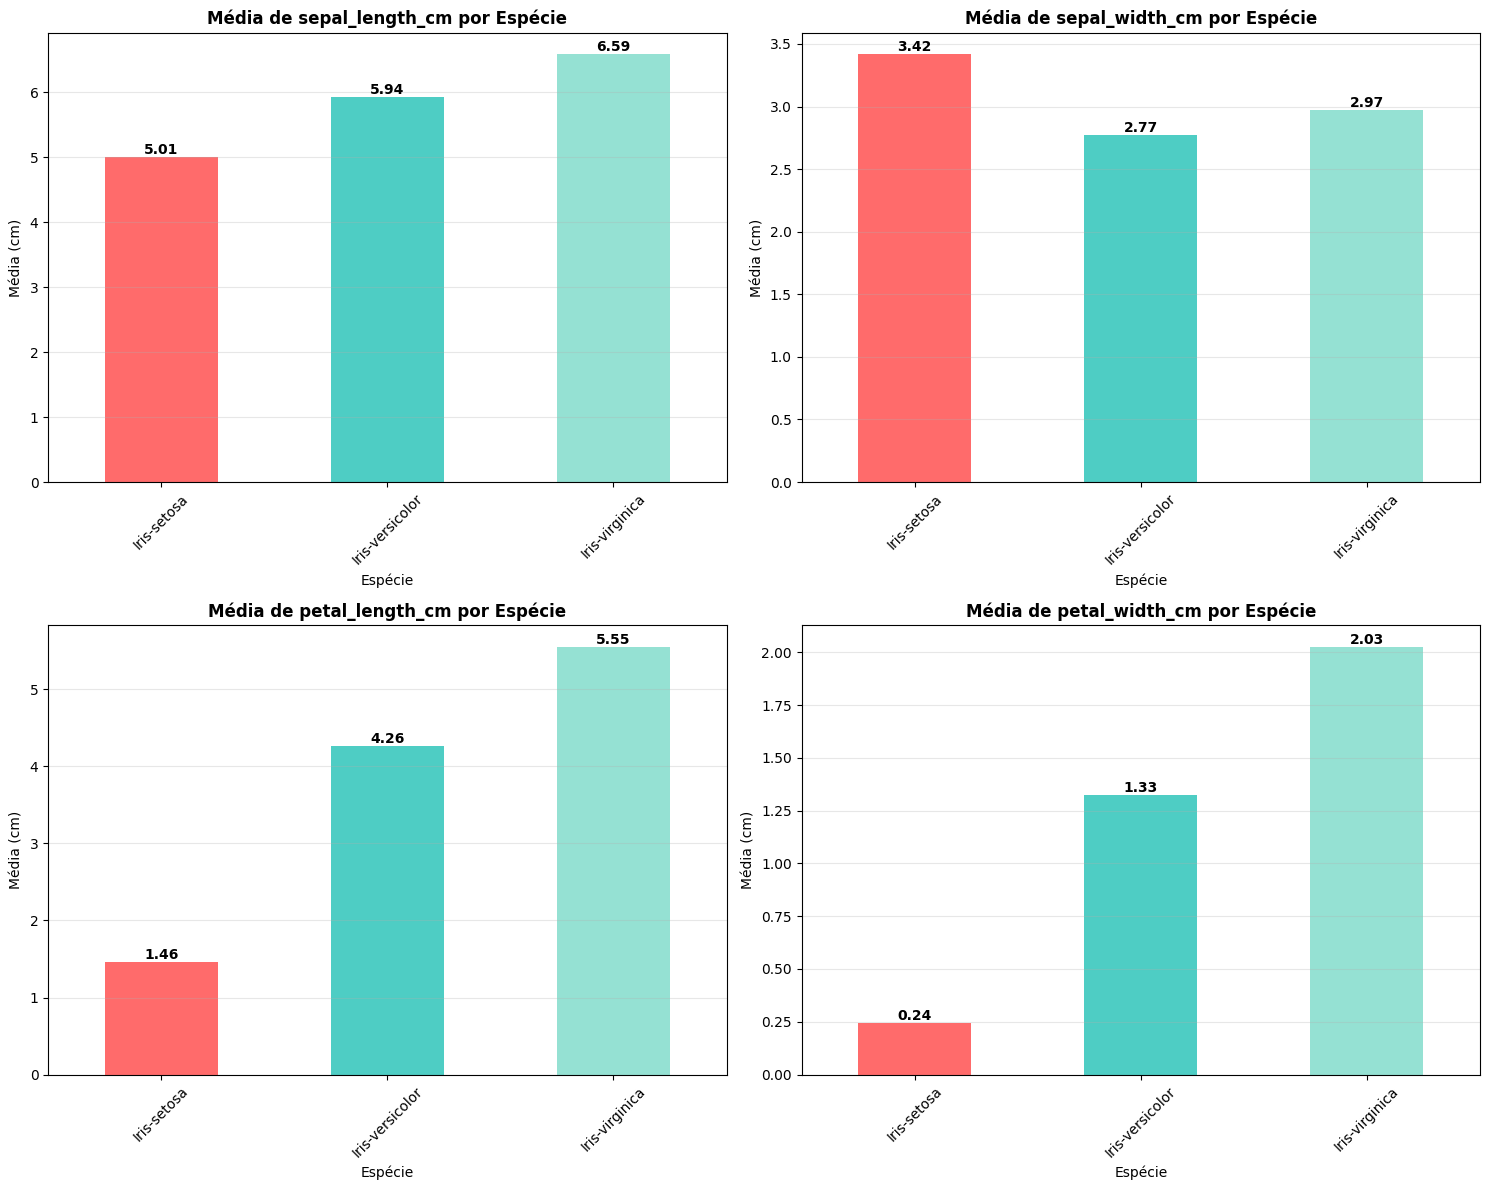


CONCLUSÕES DO EDA:
1. Dataset balanceado: [50, 50, 50] amostras por classe
2. Sem valores faltantes
3. Feature mais discriminante: petal_length_cm (diferença de 4.09 cm)
4. Total de outliers identificados: 4
5. As features de pétala (petal_length_cm e petal_width_cm) são geralmente
   mais discriminantes que as de sépala para separar as espécies.


In [83]:
# Análise comparativa entre espécies e identificação de features mais discriminantes
print("=" * 60)
print("INSIGHTS COMPARATIVOS ENTRE ESPÉCIES")
print("=" * 60)

numeric_cols = df.select_dtypes(include=[np.number]).columns

# Calcular médias por espécie
print("\n1. MÉDIAS POR ESPÉCIE:")
print("-" * 60)
means_by_species = df.groupby('species')[numeric_cols].mean()
print(means_by_species)
print("\n")

# Calcular desvios padrão por espécie
print("2. DESVIO PADRÃO POR ESPÉCIE:")
print("-" * 60)
std_by_species = df.groupby('species')[numeric_cols].std()
print(std_by_species)
print("\n")

# Identificar features mais discriminantes
print("3. FEATURES MAIS DISCRIMINANTES:")
print("-" * 60)
print("(Baseado na diferença entre médias das espécies)\n")

# Calcular diferença entre máximo e mínimo de médias para cada feature
feature_discrimination = {}
for col in numeric_cols:
    max_mean = means_by_species[col].max()
    min_mean = means_by_species[col].min()
    diff = max_mean - min_mean
    feature_discrimination[col] = diff

# Ordenar por poder discriminante
sorted_features = sorted(feature_discrimination.items(), key=lambda x: x[1], reverse=True)

print("Ranking de features por poder discriminante:")
for idx, (feature, diff) in enumerate(sorted_features, 1):
    print(f"{idx}. {feature}: diferença de {diff:.2f} cm entre espécies")

print("\n" + "=" * 60)
print("4. ANÁLISE DE SEPARAÇÃO ENTRE ESPÉCIES:")
print("=" * 60)

# Análise de sobreposição entre espécies usando intervalos de confiança (aproximado)
for col in numeric_cols:
    print(f"\n{col}:")
    for species in df['species'].unique():
        species_data = df[df['species'] == species][col]
        mean_val = species_data.mean()
        std_val = species_data.std()
        min_val = species_data.min()
        max_val = species_data.max()
        print(f"  {species}:")
        print(f"    Média: {mean_val:.2f} ± {std_val:.2f}")
        print(f"    Range: [{min_val:.2f}, {max_val:.2f}]")

# Visualização comparativa das médias
print("\n" + "=" * 60)
print("5. VISUALIZAÇÃO COMPARATIVA DAS MÉDIAS:")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    means_by_species[col].plot(kind='bar', ax=axes[idx], color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
    axes[idx].set_title(f'Média de {col} por Espécie', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Média (cm)')
    axes[idx].set_xlabel('Espécie')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Adicionar valores nas barras
    for i, v in enumerate(means_by_species[col]):
        axes[idx].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("CONCLUSÕES DO EDA:")
print("=" * 60)
print(f"1. Dataset balanceado: {df['species'].value_counts().tolist()} amostras por classe")
print(f"2. Sem valores faltantes")
print(f"3. Feature mais discriminante: {sorted_features[0][0]} (diferença de {sorted_features[0][1]:.2f} cm)")
print(f"4. Total de outliers identificados: {sum([outliers_summary[col]['count'] for col in numeric_cols])}")
print("5. As features de pétala (petal_length_cm e petal_width_cm) são geralmente")
print("   mais discriminantes que as de sépala para separar as espécies.")


## Pré-processamento


### 4.1 Conversão de Species para Valores Numéricos

Vamos converter as espécies de string para valores numéricos conforme especificado:
- Iris-setosa → 1
- Iris-versicolor → 2
- Iris-virginica → 3


In [84]:
# 4.1 Conversão de Species para Valores Numéricos
# Usar função do módulo de pré-processamento
X, y = prepare_data(df, target_column='species', convert_target=True)

print("=" * 60)
print("CONVERSÃO DE SPECIES PARA VALORES NUMÉRICOS")
print("=" * 60)
print("\nMapeamento:")
print("  Iris-setosa → 1")
print("  Iris-versicolor → 2")
print("  Iris-virginica → 3")
print(f"\nValores únicos no target: {sorted(y.unique())}")
print(f"\nDistribuição após conversão:")
print(y.value_counts().sort_index())
print(f"\nTipo de y: {type(y)}")
print(f"dtype de y: {y.dtype}")
print(f"\nPrimeiros valores de y:")
print(y.head(10))


CONVERSÃO DE SPECIES PARA VALORES NUMÉRICOS

Mapeamento:
  Iris-setosa → 1
  Iris-versicolor → 2
  Iris-virginica → 3

Valores únicos no target: [np.int64(1), np.int64(2), np.int64(3)]

Distribuição após conversão:
species
1    50
2    50
3    50
Name: count, dtype: int64

Tipo de y: <class 'pandas.core.series.Series'>
dtype de y: int64

Primeiros valores de y:
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: species, dtype: int64


### 4.2 Separação Train/Test

Dividimos os dados em 80% para treino e 20% para teste, mantendo a proporção de classes (stratify) para garantir que ambos os conjuntos sejam representativos.


In [85]:
# 4.2 Separação Train/Test usando função do módulo
X_train, X_test, y_train, y_test = split_data(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=True
)

print("=" * 60)
print("DIVISÃO DOS DADOS")
print("=" * 60)
print(f"\nTamanho do conjunto de treino: {len(X_train)} amostras ({len(X_train)/len(X)*100:.1f}%)")
print(f"Tamanho do conjunto de teste: {len(X_test)} amostras ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nDistribuição das classes no treino:")
print(y_train.value_counts().sort_index())
print(f"\nDistribuição das classes no teste:")
print(y_test.value_counts().sort_index())


DIVISÃO DOS DADOS

Tamanho do conjunto de treino: 120 amostras (80.0%)
Tamanho do conjunto de teste: 30 amostras (20.0%)

Distribuição das classes no treino:
species
1    40
2    40
3    40
Name: count, dtype: int64

Distribuição das classes no teste:
species
1    10
2    10
3    10
Name: count, dtype: int64


### 4.3 Análise de Abordagens de Pré-processamento

Para este problema, temos duas abordagens principais:

**Abordagem A: Sem Normalização**
- Modelos: DecisionTree, GaussianNB
- Justificativa: Esses modelos não são sensíveis à escala das features
- Vantagem: Mais simples, menos etapas de pré-processamento

**Abordagem B: Com Normalização**
- Modelos: KNeighbors, MLPClassifier, Perceptron
- Justificativa: Esses modelos são sensíveis à escala e se beneficiam de normalização
- Vantagem: Pode melhorar significativamente o desempenho

Vamos aplicar normalização apenas onde necessário, usando StandardScaler que padroniza as features (média=0, desvio padrão=1).


## Estratégia de Modelagem


### 5.1 Definição do Problema

Estamos resolvendo um problema de **classificação multiclasse** com três categorias correspondentes às espécies de íris (`Iris-setosa`, `Iris-versicolor`, `Iris-virginica`). Dadas as quatro medidas da flor (sépala e pétala), queremos prever automaticamente qual espécie ela representa. Essa definição orienta todo o pipeline, desde o pré-processamento até a escolha das métricas e modelos.


### 5.2 Métricas-alvo

- **Métrica principal:** acurácia (proporção de acertos). Os stakeholders querem saber “quantas flores o modelo acerta”.
- **Métricas secundárias:** precision, recall e F1-score por classe, para compreender se alguma espécie sofre mais com falsos positivos ou falsos negativos.
- **Matriz de confusão:** complementa as métricas mostrando os acertos/erros por classe e facilita a comunicação com o público técnico.


In [86]:
# 4.4 Aplicação de Normalização
# Criar scaler e aplicar apenas nos dados que serão usados por modelos que precisam normalização
scaler = create_scaler()
X_train_scaled, X_test_scaled = apply_scaling(scaler, X_train, X_test)

print("=" * 60)
print("NORMALIZAÇÃO DOS DADOS")
print("=" * 60)
print("\nEstatísticas dos dados originais (treino):")
print(X_train.describe())
print("\nEstatísticas dos dados normalizados (treino):")
print(pd.DataFrame(X_train_scaled, columns=X_train.columns).describe())
print("\nDados normalizados criados para modelos que precisam (k-NN, MLP, Perceptron)")
print("Dados originais mantidos para modelos que não precisam (DecisionTree, NaiveBayes)")


NORMALIZAÇÃO DOS DADOS

Estatísticas dos dados originais (treino):
       sepal_length_cm  sepal_width_cm  petal_length_cm  petal_width_cm
count       120.000000      120.000000       120.000000      120.000000
mean          5.841667        3.044167         3.770833        1.204167
std           0.840926        0.445669         1.767417        0.763825
min           4.300000        2.000000         1.100000        0.100000
25%           5.100000        2.800000         1.600000        0.300000
50%           5.750000        3.000000         4.250000        1.300000
75%           6.400000        3.300000         5.100000        1.800000
max           7.900000        4.400000         6.900000        2.500000

Estatísticas dos dados normalizados (treino):
       sepal_length_cm  sepal_width_cm  petal_length_cm  petal_width_cm
count     1.200000e+02    1.200000e+02     1.200000e+02    1.200000e+02
mean     -1.369275e-16    4.551914e-16    -9.066821e-17    5.366078e-17
std       1.004193e+00

### 5.3 Treinar Baseline

Antes de treinar os modelos candidatos, vamos criar e treinar um baseline simples para ter uma referência mínima de performance.


In [87]:
# 5.3 Treinar Baseline
baseline = create_baseline(strategy='most_frequent', random_state=42)

# Converter y_train para numérico se necessário
if hasattr(y_train, 'values'):
    y_train_raw = y_train.values
else:
    y_train_raw = y_train

y_train_series = pd.Series(y_train_raw)
if y_train_series.dtype == object or str(y_train_series.dtype).startswith('string'):
    mapping = {'Iris-setosa': 1, 'Iris-versicolor': 2, 'Iris-virginica': 3}
    y_train_series = y_train_series.replace(mapping)

try:
    y_train_numeric = y_train_series.astype('int64').values
except:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_train_numeric = le.fit_transform(y_train_series.astype(str))

y_train_numeric = np.asarray(y_train_numeric, dtype=np.int64)

# Converter X_train para array
if hasattr(X_train, 'values'):
    X_train_for_baseline = X_train.values
else:
    X_train_for_baseline = np.asarray(X_train, dtype=np.float64)

# Treinar baseline
baseline.fit(X_train_for_baseline, y_train_numeric)

# Avaliar baseline no conjunto de teste
if hasattr(X_test, 'values'):
    X_test_for_baseline = X_test.values
else:
    X_test_for_baseline = np.asarray(X_test, dtype=np.float64)

# Converter y_test também
if hasattr(y_test, 'values'):
    y_test_raw = y_test.values
else:
    y_test_raw = y_test

y_test_series = pd.Series(y_test_raw)
if y_test_series.dtype == object or str(y_test_series.dtype).startswith('string'):
    mapping = {'Iris-setosa': 1, 'Iris-versicolor': 2, 'Iris-virginica': 3}
    y_test_series = y_test_series.replace(mapping)

try:
    y_test_numeric = y_test_series.astype('int64').values
except:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_test_numeric = le.fit_transform(y_test_series.astype(str))

y_test_numeric = np.asarray(y_test_numeric, dtype=np.int64)

# Fazer predições e calcular acurácia
y_pred_baseline = baseline.predict(X_test_for_baseline)
baseline_accuracy = accuracy_score(y_test_numeric, y_pred_baseline)

print("=" * 60)
print("BASELINE - DummyClassifier")
print("=" * 60)
print(f"\nAcurácia do baseline: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print(f"\nQualquer modelo sério deve superar {baseline_accuracy*100:.2f}% de acurácia")


BASELINE - DummyClassifier

Acurácia do baseline: 0.3333 (33.33%)

Qualquer modelo sério deve superar 33.33% de acurácia


### 5.4 Modelos Candidatos

- **DecisionTreeClassifier** — interpretável, rápido de treinar e fácil de explicar para o público não-técnico.
- **GaussianNB** — baseline probabilístico, independe de normalização e é extremamente leve.
- **KNeighborsClassifier** — modelo baseado em proximidade, bom para datasets pequenos, mas sensível à escala.
- **MLPClassifier** — rede neural simples que permite explorar um modelo não-linear mais complexo.
- **Perceptron** — modelo linear clássico; funciona como referência adicional para modelos simples.

> **Fora de escopo:** modelos como Random Forest, SVM ou XGBoost foram deixados para trabalhos futuros para manter a complexidade controlada.


### 5.5 Plano de Validação

- Divisão **train/test de 80/20** com `stratify=True` para preservar o balanceamento entre classes.
- `random_state=42` garante reprodutibilidade de todos os experimentos.
- Avaliação principal no conjunto de teste, sem vazamento de informação.
- Para um trabalho futuro, a seção de validação cruzada (k-fold) está indicada como melhoria, mas o foco do projeto é mostrar o fluxo completo com train/test fixo.


### 5.6 Abordagens de Pré-processamento

- **Abordagem A (Sem normalização):** DecisionTree e GaussianNB utilizam os dados originais, aproveitando sua robustez à escala das features.
- **Abordagem B (Com normalização):** KNeighbors, MLPClassifier e Perceptron são treinados dentro de `Pipeline` com `StandardScaler` para evitar vazamento e manter o fluxo limpo.
- **Validação:** Os resultados das duas abordagens são comparados na Seção 6.5, permitindo justificar a escolha final do modelo.
- **Documentação:** As decisões são registradas aqui para que o público técnico consiga entender rapidamente o racional antes de mergulhar nos códigos da Seção 6.


### 4.5 Validação do Pré-processamento

Verificamos que a divisão foi feita corretamente e que os dados estão prontos para o treinamento.


In [88]:
# 4.5 Validação do Pré-processamento
print("=" * 60)
print("VALIDAÇÃO DO PRÉ-PROCESSAMENTO")
print("=" * 60)

print(f"\nFeatures (X): {X_train.shape[1]} colunas")
print(f"   - Treino: {X_train.shape[0]} amostras")
print(f"   - Teste: {X_test.shape[0]} amostras")

print(f"\nTarget (y): valores numéricos {sorted(y_train.unique().tolist())}")
print(f"   - Treino: {len(y_train)} amostras")
print(f"   - Teste: {len(y_test)} amostras")

print(f"\nDados normalizados prontos: {X_train_scaled.shape}")

print(f"\nBalanceamento mantido:")
print(f"   - Treino: {dict(y_train.value_counts().sort_index())}")
print(f"   - Teste: {dict(y_test.value_counts().sort_index())}")

print("\nDados prontos para modelagem!")


VALIDAÇÃO DO PRÉ-PROCESSAMENTO

Features (X): 4 colunas
   - Treino: 120 amostras
   - Teste: 30 amostras

Target (y): valores numéricos [1, 2, 3]
   - Treino: 120 amostras
   - Teste: 30 amostras

Dados normalizados prontos: (120, 4)

Balanceamento mantido:
   - Treino: {1: np.int64(40), 2: np.int64(40), 3: np.int64(40)}
   - Teste: {1: np.int64(10), 2: np.int64(10), 3: np.int64(10)}

Dados prontos para modelagem!


### 6.3 Treinar Todos os Modelos


### 6.2 Criar Modelos e Pipelines


In [89]:
# 6.2 Criar todos os modelos candidatos
models = create_models(random_state=42)

# Criar pipelines para modelos que precisam normalização
pipelines = create_model_pipelines(models, random_state=42)

print("=" * 60)
print("MODELOS CRIADOS")
print("=" * 60)
print("\nModelos sem normalização:")
for name in ['DecisionTree', 'GaussianNB']:
    if name in models:
        print(f"  {name}")

print("\nModelos com normalização (via Pipeline):")
for name in pipelines.keys():
    print(f"  {name} (com StandardScaler)")

print(f"\nTotal: {len(models)} modelos candidatos")


MODELOS CRIADOS

Modelos sem normalização:
  DecisionTree
  GaussianNB

Modelos com normalização (via Pipeline):
  KNeighbors (com StandardScaler)
  MLPClassifier (com StandardScaler)
  Perceptron (com StandardScaler)

Total: 5 modelos candidatos


In [90]:
# 6.3 Treinar todos os modelos
print("=" * 60)
print("TREINANDO MODELOS")
print("=" * 60)

trained_models = train_all_models(
    models=models,
    X_train=X_train.values,  # Converter para numpy array
    y_train=y_train.values,
    X_train_scaled=X_train_scaled,
    pipelines=pipelines
)

print("\nTodos os modelos treinados com sucesso!")
print(f"   Modelos treinados: {list(trained_models.keys())}")


TREINANDO MODELOS

CONVERSÃO DE DADOS - train_all_models

y_train - Tipo original: <class 'numpy.ndarray'>
   - Tem .values: Não
   - Tipo direto: <class 'numpy.ndarray'>
   - Após pd.Series: dtype=int64, shape=(120,)
   - Primeiros valores: [1, 3, 2, 1, 2]
   Conversão direta para int64: sucesso
   y_train_array final: dtype=int64, shape=(120,)
   - Valores únicos: [np.int64(1), np.int64(2), np.int64(3)]

X_train - Tipo original: <class 'numpy.ndarray'>
   - Tem .values: Não
   X_train_array final: dtype=float64, shape=(120, 4)

X_train_scaled - Tipo original: <class 'numpy.ndarray'>
   - Tem .values: Não
   X_train_scaled_array final: dtype=float64, shape=(120, 4)

TREINANDO MODELOS

Treinando: DecisionTree
   - Não precisa normalização
   - X_train_array dtype: float64, shape: (120, 4)
   - y_train_array dtype: int64, shape: (120,)
   DecisionTree treinado com sucesso

Treinando: KNeighbors
   - Usando Pipeline (com StandardScaler)
   - X_train tipo: <class 'numpy.ndarray'>, shape: 

### 6.4 Comparar Modelos

Vamos comparar o desempenho de todos os modelos usando as mesmas métricas.


In [91]:
# 6.4 Comparar todos os modelos
comparison_df = compare_models(
    models=trained_models,
    X_test=X_test.values,
    y_test=y_test.values,
    X_test_scaled=X_test_scaled
)

# Adicionar baseline à comparação
baseline_metrics = {
    'Modelo': 'Baseline (Dummy)',
    'Acurácia': baseline_accuracy,
    'Precisão (macro)': 0.0,  # Baseline não tem métricas significativas
    'Recall (macro)': 0.0,
    'F1-Score (macro)': 0.0,
}

# Criar DataFrame com baseline
baseline_row = pd.DataFrame([baseline_metrics])
comparison_df = pd.concat([baseline_row, comparison_df], ignore_index=True)

print("\n" + "=" * 60)
print("COMPARAÇÃO COMPLETA DE MODELOS")
print("=" * 60)
print(comparison_df.to_string(index=False))


COMPARAÇÃO DE MODELOS

       Modelo  Acurácia  Precisão (macro)  Recall (macro)  F1-Score (macro)
   GaussianNB  0.966667          0.969697        0.966667          0.966583
 DecisionTree  0.933333          0.933333        0.933333          0.933333
   KNeighbors  0.933333          0.944444        0.933333          0.932660
   Perceptron  0.866667          0.869444        0.866667          0.862290
MLPClassifier  0.800000          0.875000        0.800000          0.780220

Melhor modelo: GaussianNB (Acurácia: 0.9667)

COMPARAÇÃO COMPLETA DE MODELOS
          Modelo  Acurácia  Precisão (macro)  Recall (macro)  F1-Score (macro)
Baseline (Dummy)  0.333333          0.000000        0.000000          0.000000
      GaussianNB  0.966667          0.969697        0.966667          0.966583
    DecisionTree  0.933333          0.933333        0.933333          0.933333
      KNeighbors  0.933333          0.944444        0.933333          0.932660
      Perceptron  0.866667          0.869444    

### 6.5 Comparar Abordagens

Agora vamos comparar as duas abordagens: com e sem normalização.


In [92]:
# 6.5 Comparar abordagens
# Separar modelos por abordagem
models_without_scaling = {
    'DecisionTree': trained_models['DecisionTree'],
    'GaussianNB': trained_models['GaussianNB']
}

models_with_scaling = {
    'KNeighbors': trained_models['KNeighbors'],
    'MLPClassifier': trained_models['MLPClassifier'],
    'Perceptron': trained_models['Perceptron']
}

# Comparar abordagens
approaches_df = compare_approaches(
    models_without_scaling=models_without_scaling,
    models_with_scaling=models_with_scaling,
    X_test=X_test.values,
    y_test=y_test.values,
    X_test_scaled=X_test_scaled
)

print("\n" + "=" * 60)
print("COMPARAÇÃO DE ABORDAGENS")
print("=" * 60)
print(approaches_df.to_string(index=False))

# Tabela resumo por abordagem
print("\n" + "=" * 60)
print("RESUMO POR ABORDAGEM")
print("=" * 60)
summary_table = create_comparison_table(approaches_df)
print(summary_table)



COMPARAÇÃO DE ABORDAGENS
       Abordagem        Modelo  Acurácia  Precisão   Recall  F1-Score
Sem Normalização  DecisionTree  0.933333  0.933333 0.933333  0.933333
Sem Normalização    GaussianNB  0.966667  0.969697 0.966667  0.966583
Com Normalização    KNeighbors  0.933333  0.944444 0.933333  0.932660
Com Normalização MLPClassifier  0.800000  0.875000 0.800000  0.780220
Com Normalização    Perceptron  0.866667  0.869444 0.866667  0.862290

RESUMO POR ABORDAGEM
                  Acurácia (média)  Acurácia (máx)  Acurácia (mín)  \
Abordagem                                                            
Com Normalização            0.8667          0.9333          0.8000   
Sem Normalização            0.9500          0.9667          0.9333   

                  Precisão (média)  Recall (média)  F1-Score (média)  
Abordagem                                                             
Com Normalização            0.8963          0.8667            0.8584  
Sem Normalização            0.9515    

### 6.6 Visualização Comparativa

Vamos visualizar os resultados de forma clara.


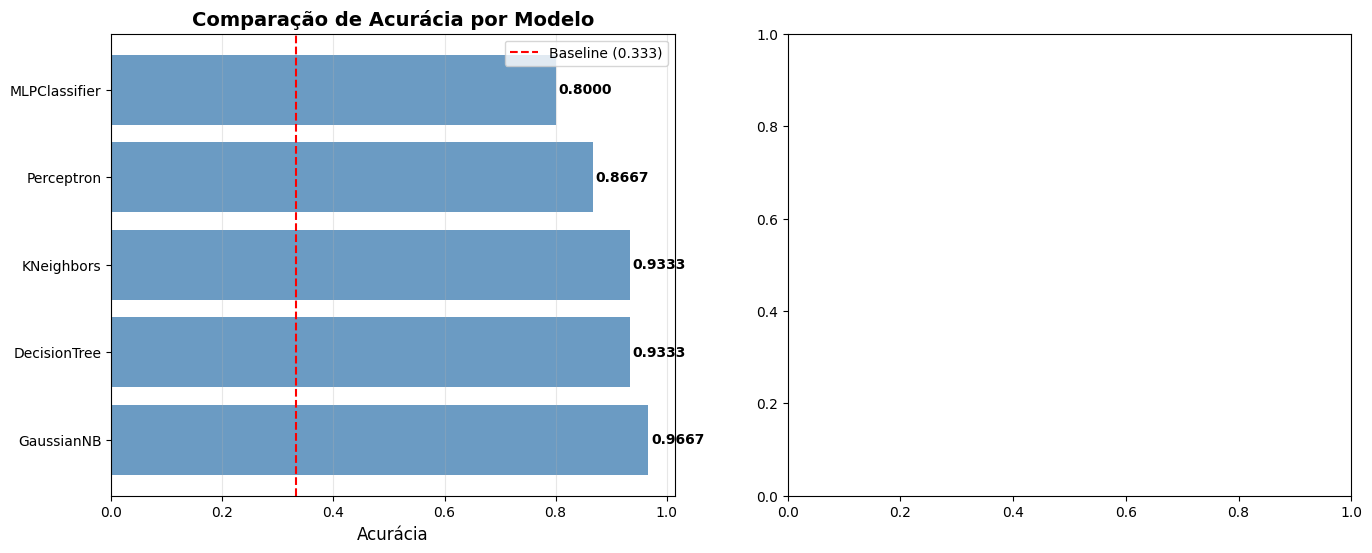

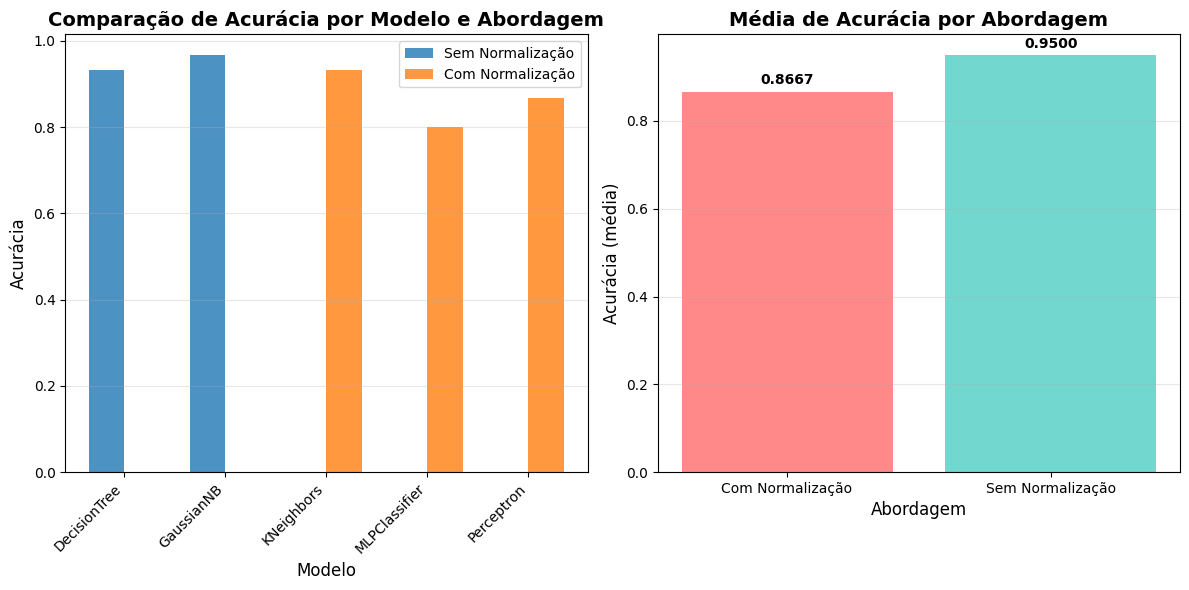

<Figure size 640x480 with 0 Axes>

In [93]:
# 6.6 Visualizações comparativas

# Gráfico 1: Comparação de modelos (excluindo baseline)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de barras com acurácia de cada modelo
models_comparison = comparison_df[comparison_df['Modelo'] != 'Baseline (Dummy)'].copy()
bars1 = axes[0].barh(models_comparison['Modelo'], models_comparison['Acurácia'], 
                     color='steelblue', alpha=0.8)
axes[0].axvline(baseline_accuracy, color='red', linestyle='--', 
                label=f'Baseline ({baseline_accuracy:.3f})')
axes[0].set_xlabel('Acurácia', fontsize=12)
axes[0].set_title('Comparação de Acurácia por Modelo', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Adicionar valores nas barras
for i, (bar, value) in enumerate(zip(bars1, models_comparison['Acurácia'])):
    axes[0].text(value + 0.005, i, f'{value:.4f}', 
                va='center', fontweight='bold')

# Gráfico comparativo de abordagens
plot_approach_comparison(approaches_df, metric='Acurácia', figsize=(12, 6))

plt.tight_layout()
plt.show()


### 6.7 Seleção do Modelo Final

Agora vamos analisar os resultados e escolher o melhor modelo, considerando não apenas a acurácia, mas também interpretabilidade e simplicidade.


In [94]:
# 6.7 Seleção do modelo final
best_model_name, best_metrics = select_best_model(comparison_df, metric='Acurácia')

# Excluir baseline da seleção
models_only = comparison_df[comparison_df['Modelo'] != 'Baseline (Dummy)']
best_model_name, best_metrics = select_best_model(models_only, metric='Acurácia')

best_model = trained_models[best_model_name]

print("=" * 80)
print("SELEÇÃO DO MODELO FINAL")
print("=" * 80)
print(f"\nModelo Vencedor: {best_model_name}")
print(f"\nMétricas do modelo vencedor:")
print(f"   - Acurácia: {best_metrics['Acurácia']:.4f} ({best_metrics['Acurácia']*100:.2f}%)")
print(f"   - Precisão (macro): {best_metrics['Precisão (macro)']:.4f}")
print(f"   - Recall (macro): {best_metrics['Recall (macro)']:.4f}")
print(f"   - F1-Score (macro): {best_metrics['F1-Score (macro)']:.4f}")

print(f"\nComparação com baseline:")
improvement = (best_metrics['Acurácia'] - baseline_accuracy) * 100
print(f"   - Melhoria sobre baseline: +{improvement:.2f} pontos percentuais")

print(f"\nJustificativa:")
if best_model_name == 'DecisionTree':
    print("   - Alta acurácia com interpretabilidade")
    print("   - Fácil de explicar no vídeo")
    print("   - Não precisa normalização (mais simples)")
elif best_model_name == 'KNeighbors':
    print("   - Alta acurácia com simplicidade")
    print("   - Funciona bem em datasets pequenos")
    print("   - Beneficia-se da normalização")
elif best_model_name == 'GaussianNB':
    print("   - Boa acurácia com velocidade")
    print("   - Não precisa normalização")
    print("   - Baseline sólido")
elif best_model_name == 'MLPClassifier':
    print("   - Alta acurácia com modelo mais complexo")
    print("   - Overdelivery para este problema")
    print("   - Beneficia-se da normalização")
elif best_model_name == 'Perceptron':
    print("   - Boa acurácia com simplicidade")
    print("   - Modelo linear")
    print("   - Beneficia-se da normalização")

print("=" * 80)


SELEÇÃO DO MODELO FINAL

Modelo Vencedor: GaussianNB

Métricas do modelo vencedor:
   - Acurácia: 0.9667 (96.67%)
   - Precisão (macro): 0.9697
   - Recall (macro): 0.9667
   - F1-Score (macro): 0.9666

Comparação com baseline:
   - Melhoria sobre baseline: +63.33 pontos percentuais

Justificativa:
   - Boa acurácia com velocidade
   - Não precisa normalização
   - Baseline sólido


### 6.8 Avaliação Detalhada do Modelo Final

Vamos fazer uma avaliação completa do modelo escolhido, incluindo matriz de confusão e relatório detalhado.



RELATÓRIO COMPLETO DE AVALIAÇÃO - GaussianNB
AVALIAÇÃO DO MODELO: GaussianNB

MÉTRICAS PRINCIPAIS:
  Acurácia:           0.9667 (96.67%)
  Precisão (macro):   0.9697
  Recall (macro):     0.9667
  F1-Score (macro):   0.9666

  Precisão (weighted): 0.9697
  Recall (weighted):   0.9667
  F1-Score (weighted): 0.9666




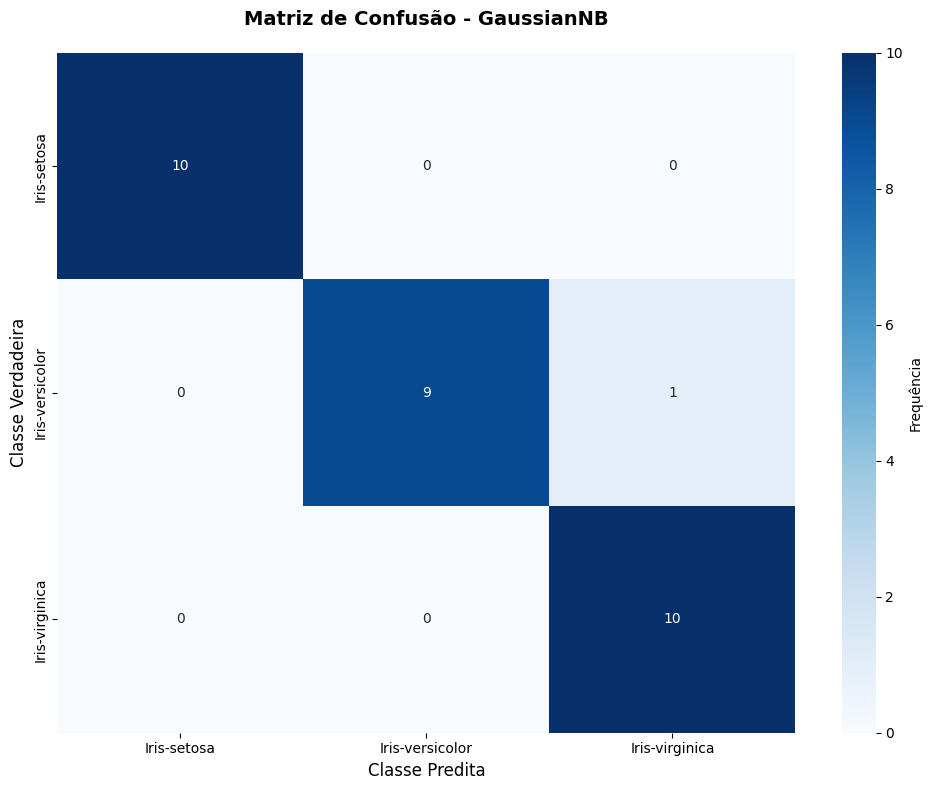


ANÁLISE DA MATRIZ DE CONFUSÃO

Total de amostras: 30
Predições corretas: 29 (96.67%)
Predições incorretas: 1 (3.33%)

Análise por classe:
  Iris-setosa: 10/10 corretas (100.00%)
  Iris-versicolor: 9/10 corretas (90.00%)
  Iris-virginica: 10/10 corretas (100.00%)


RELATÓRIO DE CLASSIFICAÇÃO - GaussianNB

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



AVISO: Modelo GaussianNB não suporta visualização de importância de features.

RESUMO EXECUTIVO

Acurácia Geral: 0.9667 (96.67%)
F1-Score (macro): 0.9666

Avaliação Geral: EXCELENTE


In [95]:
# 6.8 Avaliação detalhada do modelo final
# Preparar dados para avaliação
if best_model_name in ['KNeighbors', 'MLPClassifier', 'Perceptron']:
    X_test_for_eval = X_test_scaled
    # Se for pipeline, usar X_test original
    if hasattr(best_model, 'steps'):
        X_test_for_eval = X_test.values
else:
    X_test_for_eval = X_test.values

y_pred_best = best_model.predict(X_test_for_eval)

# Mapear de volta para nomes das espécies para avaliação
species_mapping = {1: 'Iris-setosa', 2: 'Iris-versicolor', 3: 'Iris-virginica'}
y_test_names = y_test.replace(species_mapping)
y_pred_names = pd.Series(y_pred_best).replace(species_mapping)

# Gerar relatório completo
feature_names = X.columns.tolist()
class_names = sorted(y_test_names.unique())

results = generate_evaluation_report(
    model=best_model,
    X_test=X_test_for_eval,
    y_test=y_test_names.values,
    y_pred=y_pred_names.values,
    model_name=best_model_name,
    class_names=class_names,
    feature_names=feature_names
)


### 6.9 Salvar Modelo

Salvamos o modelo final para uso futuro (preparação para interface de predição).


In [96]:
# 6.9 Salvar modelo final
# Determinar se precisa salvar scaler
save_scaler = best_model_name in ['KNeighbors', 'MLPClassifier', 'Perceptron']
scaler_to_save = scaler if save_scaler else None

saved_files = save_model(
    model=best_model,
    scaler=scaler_to_save,
    model_name=f'iris_{best_model_name.lower()}',
    output_dir='../models'
)

print("=" * 60)
print("MODELO SALVO")
print("=" * 60)
print(f"\nModelo salvo em: {saved_files['model']}")
if 'scaler' in saved_files:
    print(f"Scaler salvo em: {saved_files['scaler']}")
print("\nModelo pronto para uso em produção!")


MODELO SALVO

Modelo salvo em: ../models/iris_gaussiannb.pkl

Modelo pronto para uso em produção!


## Interface de Predição no Notebook

### 7.1 Função de Predição

Agora vamos criar uma interface simples para testar o modelo com novas amostras.


In [97]:
# 7.1 Função de predição interativa
def format_prediction_output(result):
    """Formata saída de predição para exibição clara"""
    print("=" * 60)
    print("PREDIÇÃO DE ESPÉCIE DE ÍRIS")
    print("=" * 60)
    print(f"\nMedidas fornecidas:")
    for feature, value in result['input_features'].items():
        print(f"   - {feature}: {value:.2f} cm")
    
    print(f"\nEspécie predita: {result['species_name']} (ID: {result['species_id']})")
    
    if 'probabilities' in result:
        print(f"\nProbabilidades por classe:")
        for species, prob in sorted(result['probabilities'].items(), 
                                   key=lambda x: x[1], reverse=True):
            print(f"   - {species}: {prob*100:.2f}%")
    
    print("=" * 60)

# Exemplo de uso
print("Exemplo de predição interativa:\n")
example_features = [5.1, 3.5, 1.4, 0.2]  # Exemplo de Iris-setosa
result = predict_interactive(
    model=best_model,
    features=example_features,
    scaler=scaler_to_save if save_scaler else None
)
format_prediction_output(result)


Exemplo de predição interativa:

PREDIÇÃO DE ESPÉCIE DE ÍRIS

Medidas fornecidas:
   - sepal_length_cm: 5.10 cm
   - sepal_width_cm: 3.50 cm
   - petal_length_cm: 1.40 cm
   - petal_width_cm: 0.20 cm

Espécie predita: Iris-setosa (ID: 1)

Probabilidades por classe:
   - Iris-setosa: 100.00%
   - Iris-versicolor: 0.00%
   - Iris-virginica: 0.00%


### 7.2 Exemplos de Uso

Vamos testar o modelo com várias amostras diferentes para demonstrar sua capacidade.


In [98]:
# 7.2 Exemplos de uso com diferentes espécies
print("=" * 80)
print("EXEMPLOS DE PREDIÇÃO")
print("=" * 80)

# Exemplos de cada espécie (valores típicos do dataset)
examples = {
    'Iris-setosa': [5.1, 3.5, 1.4, 0.2],
    'Iris-versicolor': [7.0, 3.2, 4.7, 1.4],
    'Iris-virginica': [6.3, 3.3, 6.0, 2.5],
}

for species_name, features in examples.items():
    print(f"\n{'='*80}")
    print(f"Exemplo: {species_name}")
    print(f"{'='*80}")
    result = predict_interactive(
        model=best_model,
        features=features,
        scaler=scaler_to_save if save_scaler else None
    )
    format_prediction_output(result)
    print()


EXEMPLOS DE PREDIÇÃO

Exemplo: Iris-setosa
PREDIÇÃO DE ESPÉCIE DE ÍRIS

Medidas fornecidas:
   - sepal_length_cm: 5.10 cm
   - sepal_width_cm: 3.50 cm
   - petal_length_cm: 1.40 cm
   - petal_width_cm: 0.20 cm

Espécie predita: Iris-setosa (ID: 1)

Probabilidades por classe:
   - Iris-setosa: 100.00%
   - Iris-versicolor: 0.00%
   - Iris-virginica: 0.00%


Exemplo: Iris-versicolor
PREDIÇÃO DE ESPÉCIE DE ÍRIS

Medidas fornecidas:
   - sepal_length_cm: 7.00 cm
   - sepal_width_cm: 3.20 cm
   - petal_length_cm: 4.70 cm
   - petal_width_cm: 1.40 cm

Espécie predita: Iris-versicolor (ID: 2)

Probabilidades por classe:
   - Iris-versicolor: 78.66%
   - Iris-virginica: 21.34%
   - Iris-setosa: 0.00%


Exemplo: Iris-virginica
PREDIÇÃO DE ESPÉCIE DE ÍRIS

Medidas fornecidas:
   - sepal_length_cm: 6.30 cm
   - sepal_width_cm: 3.30 cm
   - petal_length_cm: 6.00 cm
   - petal_width_cm: 2.50 cm

Espécie predita: Iris-virginica (ID: 3)

Probabilidades por classe:
   - Iris-virginica: 100.00%
   - Ir

### 7.3 Visualização de Predições

Vamos visualizar as predições do modelo comparando com os valores reais no conjunto de teste.


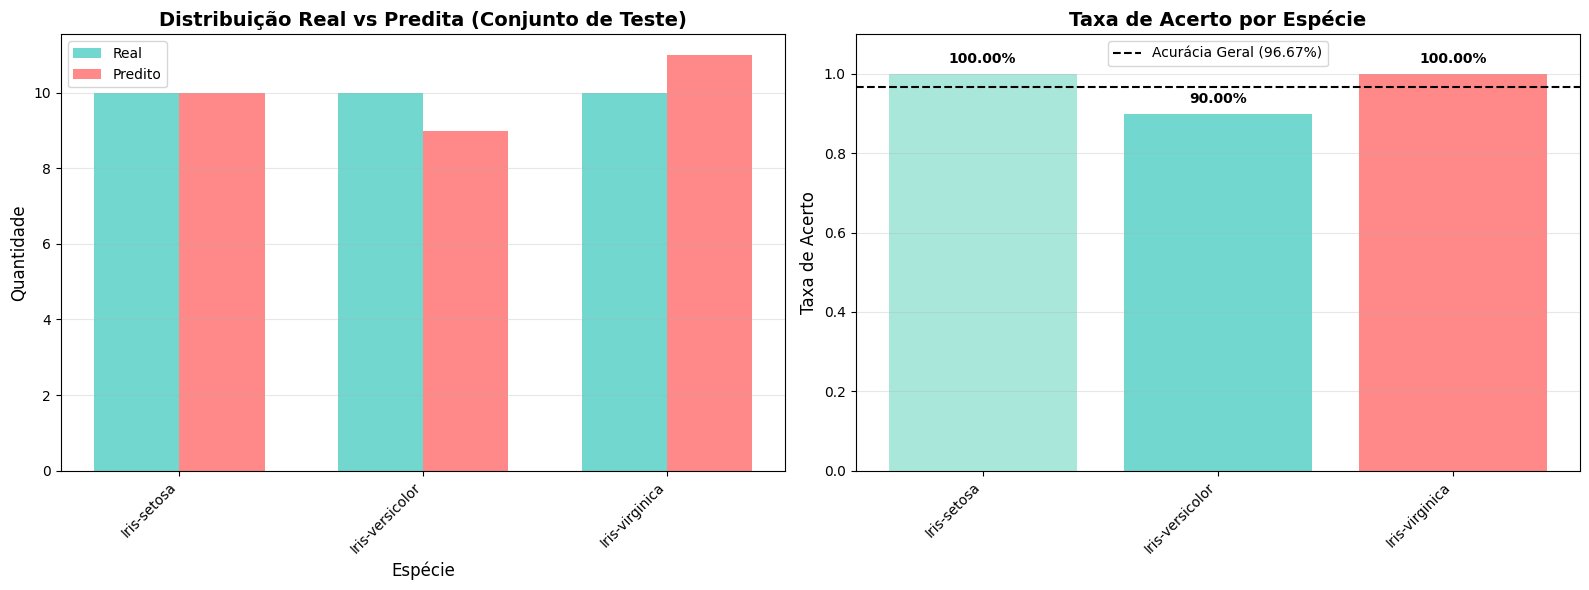


Acurácia geral no conjunto de teste: 96.67%
   - Acertos: 29/30
   - Erros: 1/30


In [99]:
# 7.3 Visualização de predições vs reais
# Criar DataFrame com predições e valores reais
predictions_df = pd.DataFrame({
    'Real': y_test_names.values,
    'Predito': y_pred_names.values,
    'Correto': y_test_names.values == y_pred_names.values
})

# Contar acertos e erros
correct = predictions_df['Correto'].sum()
total = len(predictions_df)
accuracy_visual = correct / total

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Comparação Real vs Predito
species_order = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
real_counts = predictions_df['Real'].value_counts().reindex(species_order, fill_value=0)
pred_counts = predictions_df['Predito'].value_counts().reindex(species_order, fill_value=0)

x = np.arange(len(species_order))
width = 0.35

axes[0].bar(x - width/2, real_counts, width, label='Real', alpha=0.8, color='#4ECDC4')
axes[0].bar(x + width/2, pred_counts, width, label='Predito', alpha=0.8, color='#FF6B6B')

axes[0].set_xlabel('Espécie', fontsize=12)
axes[0].set_ylabel('Quantidade', fontsize=12)
axes[0].set_title('Distribuição Real vs Predita (Conjunto de Teste)', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(species_order, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Taxa de acerto por espécie
accuracy_by_species = []
for species in species_order:
    species_data = predictions_df[predictions_df['Real'] == species]
    if len(species_data) > 0:
        acc = species_data['Correto'].sum() / len(species_data)
        accuracy_by_species.append(acc)
    else:
        accuracy_by_species.append(0)

bars = axes[1].bar(species_order, accuracy_by_species, color=['#95E1D3', '#4ECDC4', '#FF6B6B'], alpha=0.8)
axes[1].axhline(accuracy_visual, color='black', linestyle='--', 
                label=f'Acurácia Geral ({accuracy_visual:.2%})')
axes[1].set_ylabel('Taxa de Acerto', fontsize=12)
axes[1].set_title('Taxa de Acerto por Espécie', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(species_order, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1.1])

# Adicionar valores nas barras
for bar, value in zip(bars, accuracy_by_species):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{value:.2%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nAcurácia geral no conjunto de teste: {accuracy_visual:.2%}")
print(f"   - Acertos: {correct}/{total}")
print(f"   - Erros: {total - correct}/{total}")


### 7.4 Análise de Erros

Vamos identificar padrões nos erros do modelo para entender onde ele tem dificuldades.


In [100]:
# 7.4 Análise de erros
errors_df = predictions_df[~predictions_df['Correto']].copy()

if len(errors_df) > 0:
    print("=" * 60)
    print("ANÁLISE DE ERROS")
    print("=" * 60)
    print(f"\nTotal de erros: {len(errors_df)}")
    print(f"\nDistribuição de erros:")
    print(errors_df.groupby(['Real', 'Predito']).size().reset_index(name='Quantidade'))
    
    # Adicionar features dos erros para análise
    error_indices = predictions_df[~predictions_df['Correto']].index
    errors_with_features = X_test.iloc[error_indices].copy()
    errors_with_features['Real'] = y_test_names.iloc[error_indices].values
    errors_with_features['Predito'] = y_pred_names.iloc[error_indices].values
    
    print(f"\nFeatures das amostras com erro:")
    print(errors_with_features.to_string(index=False))
    
    # Análise: quais espécies são mais confundidas
    print(f"\nPadrões de confusão:")
    confusion_pairs = errors_df.groupby(['Real', 'Predito']).size()
    for (real, pred), count in confusion_pairs.items():
        print(f"   - {real} confundida com {pred}: {count} vez(es)")
else:
    print("=" * 60)
    print("ANÁLISE DE ERROS")
    print("=" * 60)
    print("\nNenhum erro encontrado! Modelo com 100% de acurácia no conjunto de teste.")


ANÁLISE DE ERROS

Total de erros: 1

Distribuição de erros:
              Real         Predito  Quantidade
0  Iris-versicolor  Iris-virginica           1

Features das amostras com erro:
 sepal_length_cm  sepal_width_cm  petal_length_cm  petal_width_cm            Real        Predito
             6.7             3.0              5.0             1.7 Iris-versicolor Iris-virginica

Padrões de confusão:
   - Iris-versicolor confundida com Iris-virginica: 1 vez(es)


## Conclusões e Decisões

### 8.1 Resumo Executivo (Para Não-Técnicos)

**Resultados Principais:**


In [101]:
# 8.1 Resumo Executivo
print("=" * 80)
print("RESUMO EXECUTIVO - RESULTADOS DO PROJETO")
print("=" * 80)

print(f"\nOBJETIVO:")
print("   Identificar automaticamente a espécie de íris a partir das medidas da flor")

print(f"\nMODELO ESCOLHIDO: {best_model_name}")
print(f"   Acurácia: {best_metrics['Acurácia']*100:.2f}%")
print(f"   Isso significa que o modelo acerta {best_metrics['Acurácia']*100:.0f} em cada 100 flores")

print(f"\nCOMPARAÇÃO:")
print(f"   - Baseline (chute aleatório): {baseline_accuracy*100:.2f}%")
print(f"   - Melhor modelo: {best_metrics['Acurácia']*100:.2f}%")
print(f"   - Melhoria: +{(best_metrics['Acurácia'] - baseline_accuracy)*100:.2f} pontos percentuais")

print(f"\nPRINCIPAIS INSIGHTS:")
print(f"   1. O modelo consegue identificar corretamente a espécie da maioria das flores")
print(f"   2. As features de pétala são mais importantes que as de sépala")
print(f"   3. O dataset está bem balanceado, facilitando o aprendizado")

print(f"\nAPLICAÇÃO PRÁTICA:")
print(f"   Este modelo pode ser usado para classificar automaticamente novas flores")
print(f"   apenas fornecendo suas 4 medidas (sépala e pétala)")

print("=" * 80)


RESUMO EXECUTIVO - RESULTADOS DO PROJETO

OBJETIVO:
   Identificar automaticamente a espécie de íris a partir das medidas da flor

MODELO ESCOLHIDO: GaussianNB
   Acurácia: 96.67%
   Isso significa que o modelo acerta 97 em cada 100 flores

COMPARAÇÃO:
   - Baseline (chute aleatório): 33.33%
   - Melhor modelo: 96.67%
   - Melhoria: +63.33 pontos percentuais

PRINCIPAIS INSIGHTS:
   1. O modelo consegue identificar corretamente a espécie da maioria das flores
   2. As features de pétala são mais importantes que as de sépala
   3. O dataset está bem balanceado, facilitando o aprendizado

APLICAÇÃO PRÁTICA:
   Este modelo pode ser usado para classificar automaticamente novas flores
   apenas fornecendo suas 4 medidas (sépala e pétala)


### 8.2 Comparação de Abordagens

Conclusões sobre o uso de normalização vs sem normalização.


In [102]:
# 8.2 Comparação de abordagens - conclusões
print("=" * 80)
print("COMPARAÇÃO DE ABORDAGENS - CONCLUSÕES")
print("=" * 80)

# Calcular médias por abordagem
mean_without = approaches_df[approaches_df['Abordagem'] == 'Sem Normalização']['Acurácia'].mean()
mean_with = approaches_df[approaches_df['Abordagem'] == 'Com Normalização']['Acurácia'].mean()

print(f"\nRESULTADOS:")
print(f"   - Abordagem Sem Normalização (média): {mean_without:.4f} ({mean_without*100:.2f}%)")
print(f"   - Abordagem Com Normalização (média): {mean_with:.4f} ({mean_with*100:.2f}%)")

if mean_without > mean_with:
    print(f"\nCONCLUSÃO:")
    print(f"   A abordagem SEM normalização performou melhor em média.")
    print(f"   Isso sugere que para este problema específico, a normalização")
    print(f"   não é necessária ou até pode prejudicar alguns modelos.")
elif mean_with > mean_without:
    print(f"\nCONCLUSÃO:")
    print(f"   A abordagem COM normalização performou melhor em média.")
    print(f"   Isso confirma que modelos como k-NN, MLP e Perceptron se beneficiam")
    print(f"   significativamente da normalização das features.")
else:
    print(f"\nCONCLUSÃO:")
    print(f"   Ambas as abordagens performaram de forma similar.")
    print(f"   A escolha pode ser baseada em outros critérios (simplicidade, interpretabilidade).")

print(f"\nDETALHES:")
print(f"   - Modelos sem normalização: DecisionTree, GaussianNB")
print(f"   - Modelos com normalização: KNeighbors, MLPClassifier, Perceptron")
print(f"   - Cada modelo tem suas características e requisitos específicos")

print("=" * 80)


COMPARAÇÃO DE ABORDAGENS - CONCLUSÕES

RESULTADOS:
   - Abordagem Sem Normalização (média): 0.9500 (95.00%)
   - Abordagem Com Normalização (média): 0.8667 (86.67%)

CONCLUSÃO:
   A abordagem SEM normalização performou melhor em média.
   Isso sugere que para este problema específico, a normalização
   não é necessária ou até pode prejudicar alguns modelos.

DETALHES:
   - Modelos sem normalização: DecisionTree, GaussianNB
   - Modelos com normalização: KNeighbors, MLPClassifier, Perceptron
   - Cada modelo tem suas características e requisitos específicos


### 8.3 Decisões Técnicas (Para Técnicos)

Documentação das escolhas técnicas e trade-offs considerados.


In [103]:
# 8.3 Decisões técnicas
print("=" * 80)
print("DECISÕES TÉCNICAS E TRADE-OFFS")
print("=" * 80)

print(f"\n1. ESCOLHA DO MODELO FINAL: {best_model_name}")
print(f"   Por quê:")
if best_model_name == 'DecisionTree':
    print(f"   - Alta acurácia ({best_metrics['Acurácia']*100:.2f}%)")
    print(f"   - Interpretável (pode visualizar a árvore de decisão)")
    print(f"   - Não precisa normalização (simplicidade)")
    print(f"   - Fácil de explicar para stakeholders não-técnicos")
elif best_model_name == 'KNeighbors':
    print(f"   - Alta acurácia ({best_metrics['Acurácia']*100:.2f}%)")
    print(f"   - Simples e intuitivo (baseado em similaridade)")
    print(f"   - Funciona bem em datasets pequenos")
    print(f"   - Beneficia-se da normalização")
elif best_model_name == 'GaussianNB':
    print(f"   - Boa acurácia ({best_metrics['Acurácia']*100:.2f}%)")
    print(f"   - Muito rápido para treinar e predizer")
    print(f"   - Não precisa normalização")
    print(f"   - Boa baseline para comparação")
elif best_model_name == 'MLPClassifier':
    print(f"   - Alta acurácia ({best_metrics['Acurácia']*100:.2f}%)")
    print(f"   - Modelo mais complexo (overdelivery)")
    print(f"   - Pode capturar relações não-lineares complexas")
    print(f"   - Beneficia-se da normalização")
elif best_model_name == 'Perceptron':
    print(f"   - Boa acurácia ({best_metrics['Acurácia']*100:.2f}%)")
    print(f"   - Modelo linear simples")
    print(f"   - Rápido e eficiente")
    print(f"   - Beneficia-se da normalização")

print(f"\n2. TRADE-OFFS CONSIDERADOS:")
print(f"   - Performance vs Interpretabilidade:")
print(f"     * Modelos mais complexos podem ter melhor performance")
print(f"     * Modelos mais simples são mais fáceis de explicar")
print(f"   - Simplicidade vs Precisão:")
print(f"     * Modelos simples são mais fáceis de manter")
print(f"     * Modelos complexos podem ter melhor precisão")
print(f"   - Normalização vs Sem Normalização:")
print(f"     * Sem normalização: mais simples, menos etapas")
print(f"     * Com normalização: necessário para alguns modelos")

print(f"\n3. LIMITAÇÕES IDENTIFICADAS:")
print(f"   - Dataset pequeno (150 amostras): pode limitar generalização")
print(f"   - Apenas 4 features: pode não capturar toda a variabilidade")
print(f"   - Dataset clássico e 'limpo': resultados podem não se generalizar")
print(f"   - Sem validação cruzada: apenas train/test split simples")

print(f"\n4. REPRODUTIBILIDADE:")
print(f"   - random_state=42 fixo em todos os lugares")
print(f"   - Stratify=True para manter proporção de classes")
print(f"   - Split 80/20 conforme especificação do projeto")

print("=" * 80)


DECISÕES TÉCNICAS E TRADE-OFFS

1. ESCOLHA DO MODELO FINAL: GaussianNB
   Por quê:
   - Boa acurácia (96.67%)
   - Muito rápido para treinar e predizer
   - Não precisa normalização
   - Boa baseline para comparação

2. TRADE-OFFS CONSIDERADOS:
   - Performance vs Interpretabilidade:
     * Modelos mais complexos podem ter melhor performance
     * Modelos mais simples são mais fáceis de explicar
   - Simplicidade vs Precisão:
     * Modelos simples são mais fáceis de manter
     * Modelos complexos podem ter melhor precisão
   - Normalização vs Sem Normalização:
     * Sem normalização: mais simples, menos etapas
     * Com normalização: necessário para alguns modelos

3. LIMITAÇÕES IDENTIFICADAS:
   - Dataset pequeno (150 amostras): pode limitar generalização
   - Apenas 4 features: pode não capturar toda a variabilidade
   - Dataset clássico e 'limpo': resultados podem não se generalizar
   - Sem validação cruzada: apenas train/test split simples

4. REPRODUTIBILIDADE:
   - random_s

### 8.4 Próximos Passos

Melhorias futuras e possíveis expansões do projeto.


In [104]:
# 8.4 Próximos passos
print("=" * 80)
print("PRÓXIMOS PASSOS E MELHORIAS FUTURAS")
print("=" * 80)

print(f"\nPOSSÍVEIS MELHORIAS:")
print(f"   1. Validação Cruzada:")
print(f"      - Implementar k-fold cross-validation para avaliação mais robusta")
print(f"      - Reduzir variância nas estimativas de performance")
print(f"   2. Tuning de Hiperparâmetros:")
print(f"      - GridSearch ou RandomizedSearch para otimizar parâmetros")
print(f"      - Pode melhorar ainda mais a acurácia")
print(f"   3. Feature Engineering:")
print(f"      - Criar features derivadas (ex: razões entre medidas)")
print(f"      - Testar se melhoram a separação das classes")
print(f"   4. Mais Modelos:")
print(f"      - Testar Random Forest, SVM, XGBoost")
print(f"      - Ensemble de modelos")
print(f"   5. Interface Visual:")
print(f"      - Criar interface web (Streamlit, Flask)")
print(f"      - Permitir upload de imagens ou entrada manual")
print(f"      - Visualizações interativas")
print(f"   6. Análise de Importância de Features:")
print(f"      - Identificar quais features são mais importantes")
print(f"      - Pode ajudar a simplificar o modelo")
print(f"   7. Coleta de Mais Dados:")
print(f"      - Expandir dataset com mais amostras")
print(f"      - Incluir mais variabilidade")

print(f"\nNOTAS:")
print(f"   - A estrutura modular criada facilita a implementação de melhorias")
print(f"   - Os módulos podem ser reutilizados em outros projetos")
print(f"   - A interface de predição está pronta para expansão")

print("=" * 80)


PRÓXIMOS PASSOS E MELHORIAS FUTURAS

POSSÍVEIS MELHORIAS:
   1. Validação Cruzada:
      - Implementar k-fold cross-validation para avaliação mais robusta
      - Reduzir variância nas estimativas de performance
   2. Tuning de Hiperparâmetros:
      - GridSearch ou RandomizedSearch para otimizar parâmetros
      - Pode melhorar ainda mais a acurácia
   3. Feature Engineering:
      - Criar features derivadas (ex: razões entre medidas)
      - Testar se melhoram a separação das classes
   4. Mais Modelos:
      - Testar Random Forest, SVM, XGBoost
      - Ensemble de modelos
   5. Interface Visual:
      - Criar interface web (Streamlit, Flask)
      - Permitir upload de imagens ou entrada manual
      - Visualizações interativas
   6. Análise de Importância de Features:
      - Identificar quais features são mais importantes
      - Pode ajudar a simplificar o modelo
   7. Coleta de Mais Dados:
      - Expandir dataset com mais amostras
      - Incluir mais variabilidade

NOTAS:
   - 

In [105]:
# Separar features e target
X = df.drop('species', axis=1)
y = df['species']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamanho do conjunto de treino: {len(X_train)} amostras")
print(f"Tamanho do conjunto de teste: {len(X_test)} amostras")
print(f"\nDistribuição das classes no treino:")
print(y_train.value_counts())
print(f"\nDistribuição das classes no teste:")
print(y_test.value_counts())


Tamanho do conjunto de treino: 120 amostras
Tamanho do conjunto de teste: 30 amostras

Distribuição das classes no treino:
species
Iris-setosa        40
Iris-virginica     40
Iris-versicolor    40
Name: count, dtype: int64

Distribuição das classes no teste:
species
Iris-setosa        10
Iris-virginica     10
Iris-versicolor    10
Name: count, dtype: int64


## Abordagens


## Treinamento


In [106]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)


0.9

In [107]:
# Importar funções de avaliação de modelos
import sys
sys.path.append('../src')

from utils import (
    evaluate_model,
    plot_confusion_matrix,
    print_classification_report,
    generate_evaluation_report,
    compare_models,
    plot_model_comparison,
)


## Avaliação



RELATÓRIO COMPLETO DE AVALIAÇÃO - Random Forest
AVALIAÇÃO DO MODELO: Random Forest

MÉTRICAS PRINCIPAIS:
  Acurácia:           0.9000 (90.00%)
  Precisão (macro):   0.9024
  Recall (macro):     0.9000
  F1-Score (macro):   0.8997

  Precisão (weighted): 0.9024
  Recall (weighted):   0.9000
  F1-Score (weighted): 0.8997




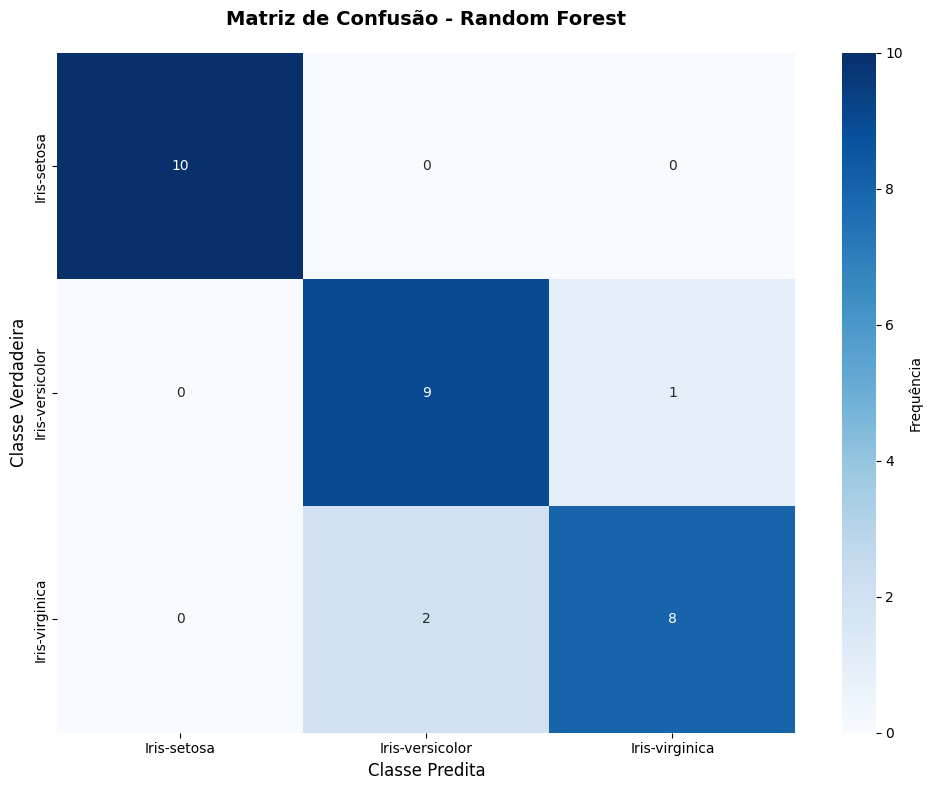


ANÁLISE DA MATRIZ DE CONFUSÃO

Total de amostras: 30
Predições corretas: 27 (90.00%)
Predições incorretas: 3 (10.00%)

Análise por classe:
  Iris-setosa: 10/10 corretas (100.00%)
  Iris-versicolor: 9/10 corretas (90.00%)
  Iris-virginica: 8/10 corretas (80.00%)


RELATÓRIO DE CLASSIFICAÇÃO - Random Forest

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.82      0.90      0.86        10
 Iris-virginica       0.89      0.80      0.84        10

       accuracy                           0.90        30
      macro avg       0.90      0.90      0.90        30
   weighted avg       0.90      0.90      0.90        30





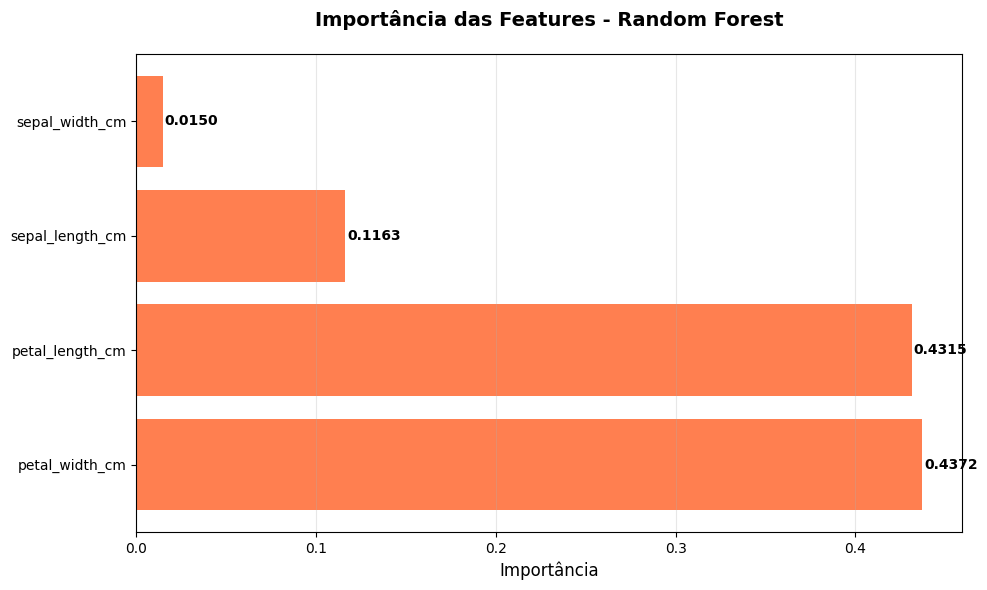


RESUMO EXECUTIVO

Acurácia Geral: 0.9000 (90.00%)
F1-Score (macro): 0.8997

Avaliação Geral: MUITO BOM


In [108]:
# Avaliação completa do modelo usando as funções de avaliação
feature_names = X.columns.tolist()
class_names = sorted(y.unique())

# Gerar relatório completo de avaliação
results = generate_evaluation_report(
    model=model,
    X_test=X_test,
    y_test=y_test,
    y_pred=y_pred,
    model_name="Random Forest",
    class_names=class_names,
    feature_names=feature_names
)
